In [1]:
import math
import pydot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import seed
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout 
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('../data/train.csv')
data.head()

Unnamed: 0  Term  NoEmp  NewExist  CreateJob  RetainedJob  FranchiseCode  \
0           0   163     21       1.0          0            0              1   
1           1    84      6       1.0          4            0              0   
2           2   242     45       1.0          4           90              0   
3           3   237      4       1.0          0            0              0   
4           4   184      0       1.0          0            0              0   

  RevLineCr LowDoc DisbursementDate  MIS_Status  Sector ApprovalDate  \
0         N      N        31-Jan-98           1       0    22-Sep-06   
1         0      N        31-Oct-93           1      62    30-Jun-92   
2         N      N        31-Aug-01           1      42    18-Apr-01   
3         N      N        31-Aug-07           1      33     6-Oct-03   
4         N      N         8-Jun-83           1       0    17-Dec-99   

   ApprovalFY       City State BankState DisbursementGross        GrAppv  \
0        2006    PHOENIX    AZ        SD       $80,000.00    $80,000.00    
1        1992  MCALESTER    OK        OK      $287,000.00   $287,000.00    
2        2001  HAWTHORNE    NJ        NJ       $31,983.00    $30,000.00    
3        2004  NASHVILLE    TN        SD      $229,000.00   $229,000.00    
4        2000     POMONA    CA        CA      $525,000.00   $525,000.00    

       SBA_Appv  UrbanRural  
0   $68,000.00            0  
1  $229,600.00            0  
2   $15,000.00            1  
3  $229,000.00            0  
4  $393,750.00            0

I think it will be interesting to predict MIS_Status value (Loan status charged off = CHGOFF, Paid in full = PIF)

In [3]:
data.drop(data[data['MIS_Status'].isnull()].index, axis = 0, inplace = True)

In [4]:
data

Unnamed: 0  Term  NoEmp  NewExist  CreateJob  RetainedJob  \
0               0   163     21       1.0          0            0   
1               1    84      6       1.0          4            0   
2               2   242     45       1.0          4           90   
3               3   237      4       1.0          0            0   
4               4   184      0       1.0          0            0   
...           ...   ...    ...       ...        ...          ...   
42302       42302   283     14       1.0          0            0   
42303       42303    53      2       1.0          0            0   
42304       42304    59      6       2.0          0            0   
42305       42305   295     18       1.0          0            8   
42306       42306    84      4       1.0          0            8   

       FranchiseCode RevLineCr LowDoc DisbursementDate  MIS_Status  Sector  \
0                  1         N      N        31-Jan-98           1       0   
1                  0         0      N        31-Oct-93           1      62   
2                  0         N      N        31-Aug-01           1      42   
3                  0         N      N        31-Aug-07           1      33   
4                  0         N      N         8-Jun-83           1       0   
...              ...       ...    ...              ...         ...     ...   
42302              1         N      N        31-Jan-98           1       0   
42303              0         Y      N         3-Apr-91           1      42   
42304              1         N      N        28-Feb-03           1      42   
42305              0         N      N        10-Dec-97           1      42   
42306              0         N      N        31-Oct-89           1      72   

      ApprovalDate  ApprovalFY          City State BankState  \
0        22-Sep-06        2006       PHOENIX    AZ        SD   
1        30-Jun-92        1992     MCALESTER    OK        OK   
2        18-Apr-01        2001     HAWTHORNE    NJ        NJ   
3         6-Oct-03        2004     NASHVILLE    TN        SD   
4        17-Dec-99        2000        POMONA    CA        CA   
...            ...         ...           ...   ...       ...   
42302     2-Mar-95        1995  PHILADELPHIA    PA        PA   
42303     6-Jun-07        2007   LOS ANGELES    CA        SD   
42304    14-Mar-03        2003      COLUMBUS    OH        OH   
42305    23-Aug-89        1989       CLOQUET    MN        MN   
42306    12-Apr-11        2011   SAN GABRIEL    CA        NC   

      DisbursementGross        GrAppv      SBA_Appv  UrbanRural  
0           $80,000.00    $80,000.00    $68,000.00            0  
1          $287,000.00   $287,000.00   $229,600.00            0  
2           $31,983.00    $30,000.00    $15,000.00            1  
3          $229,000.00   $229,000.00   $229,000.00            0  
4          $525,000.00   $525,000.00   $393,750.00            0  
...                 ...           ...           ...         ...  
42302       $80,000.00    $80,000.00    $68,000.00            0  
42303        $5,000.00     $5,000.00     $4,250.00            1  
42304       $60,000.00    $60,000.00    $51,000.00            0  
42305      $294,000.00   $294,000.00   $220,500.00            0  
42306       $67,500.00    $67,500.00    $50,625.00            0  

[42307 rows x 21 columns]

# Splits

In [5]:
df, validation_df  = train_test_split(data,
                                test_size=0.35,
                                random_state = 101)

In [6]:
df_train, df_test  = train_test_split(df,
                                test_size=0.25,
                                random_state = 101)

In [7]:
del data

# EDA

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20624 entries, 24039 to 26779
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         20624 non-null  int64  
 1   Term               20624 non-null  int64  
 2   NoEmp              20624 non-null  int64  
 3   NewExist           20624 non-null  float64
 4   CreateJob          20624 non-null  int64  
 5   RetainedJob        20624 non-null  int64  
 6   FranchiseCode      20624 non-null  int64  
 7   RevLineCr          20119 non-null  object 
 8   LowDoc             20358 non-null  object 
 9   DisbursementDate   20561 non-null  object 
 10  MIS_Status         20624 non-null  int64  
 11  Sector             20624 non-null  int64  
 12  ApprovalDate       20624 non-null  object 
 13  ApprovalFY         20624 non-null  int64  
 14  City               20624 non-null  object 
 15  State              20624 non-null  object 
 16  BankState         

In [9]:
df_train.describe()

Unnamed: 0          Term         NoEmp      NewExist     CreateJob  \
count  20624.000000  20624.000000  20624.000000  20624.000000  20624.000000   
mean   21215.977308    108.448894      9.670772      1.207913      2.184542   
std    12261.668338     84.888505     17.452114      0.405824      5.091643   
min        1.000000      0.000000      0.000000      1.000000      0.000000   
25%    10567.750000     56.000000      2.000000      1.000000      0.000000   
50%    21248.500000     82.000000      4.000000      1.000000      0.000000   
75%    31884.750000    168.000000     12.000000      1.000000      2.000000   
max    42306.000000    360.000000    202.000000      2.000000     57.000000   

        RetainedJob  FranchiseCode    MIS_Status        Sector    ApprovalFY  \
count  20624.000000   20624.000000  20624.000000  20624.000000  20624.000000   
mean       3.481575    1867.218629      0.891874     33.111860   2001.549263   
std        8.175371   10318.598921      0.310548     22.327228      5.861574   
min        0.000000       0.000000      0.000000      0.000000   1974.000000   
25%        0.000000       0.000000      1.000000     22.000000   1997.000000   
50%        0.000000       0.000000      1.000000     33.000000   2003.000000   
75%        3.000000       1.000000      1.000000     44.000000   2006.000000   
max      140.000000   90709.000000      1.000000     81.000000   2014.000000   

         UrbanRural  
count  20624.000000  
mean       0.586404  
std        0.743037  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        2.000000

N\A values

In [10]:
df.isnull().sum()

Unnamed: 0             0
Term                   0
NoEmp                  0
NewExist               0
CreateJob              0
RetainedJob            0
FranchiseCode          0
RevLineCr            695
LowDoc               342
DisbursementDate      87
MIS_Status             0
Sector                 0
ApprovalDate           0
ApprovalFY             0
City                   0
State                  0
BankState              8
DisbursementGross      0
GrAppv                 0
SBA_Appv               0
UrbanRural             0
dtype: int64

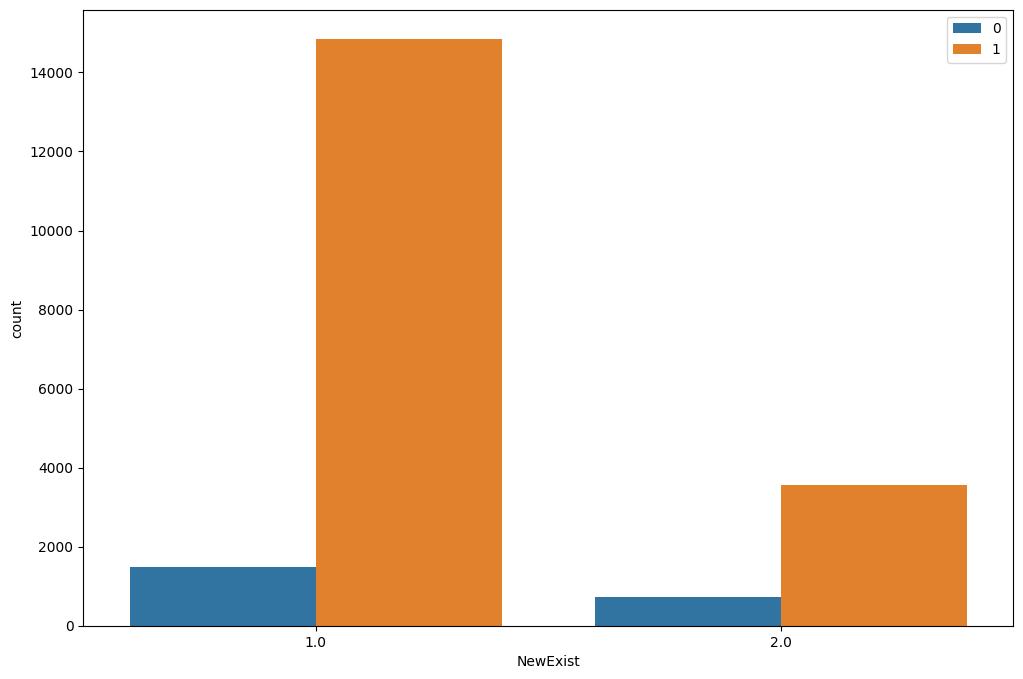

In [11]:
plt.figure(figsize=(12,8))
sns.countplot(x="NewExist", hue="MIS_Status", data=df_train)
plt.legend()
plt.show()

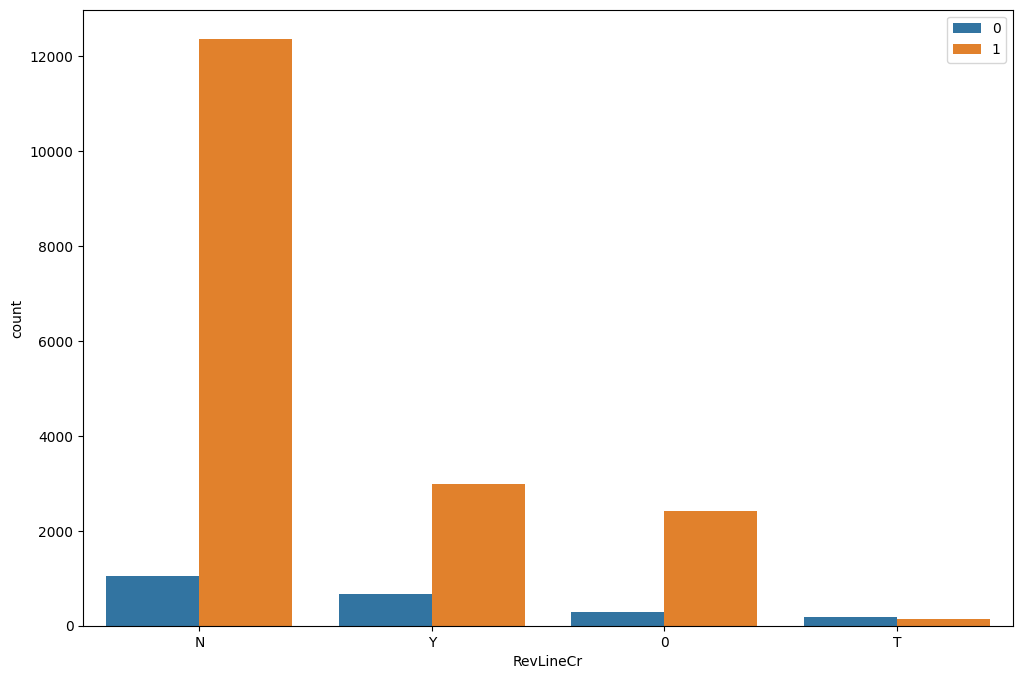

In [12]:
plt.figure(figsize=(12,8))
sns.countplot(x="RevLineCr", hue="MIS_Status", data=df_train)
plt.legend()
plt.show()

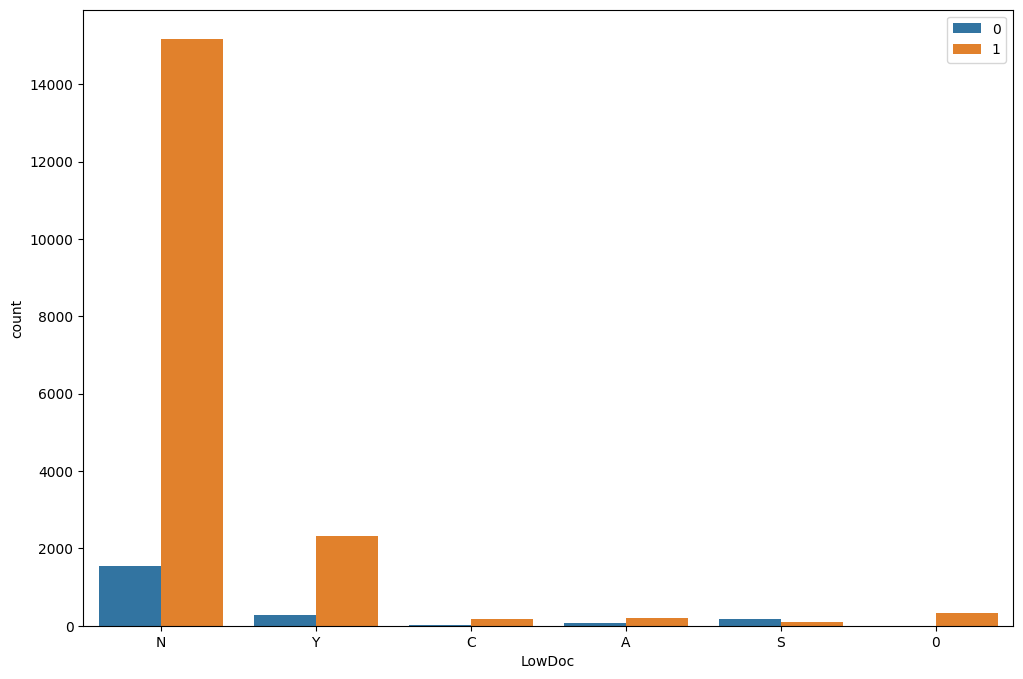

In [13]:
plt.figure(figsize=(12,8))
sns.countplot(x="LowDoc", hue="MIS_Status", data=df_train)
plt.legend()
plt.show()

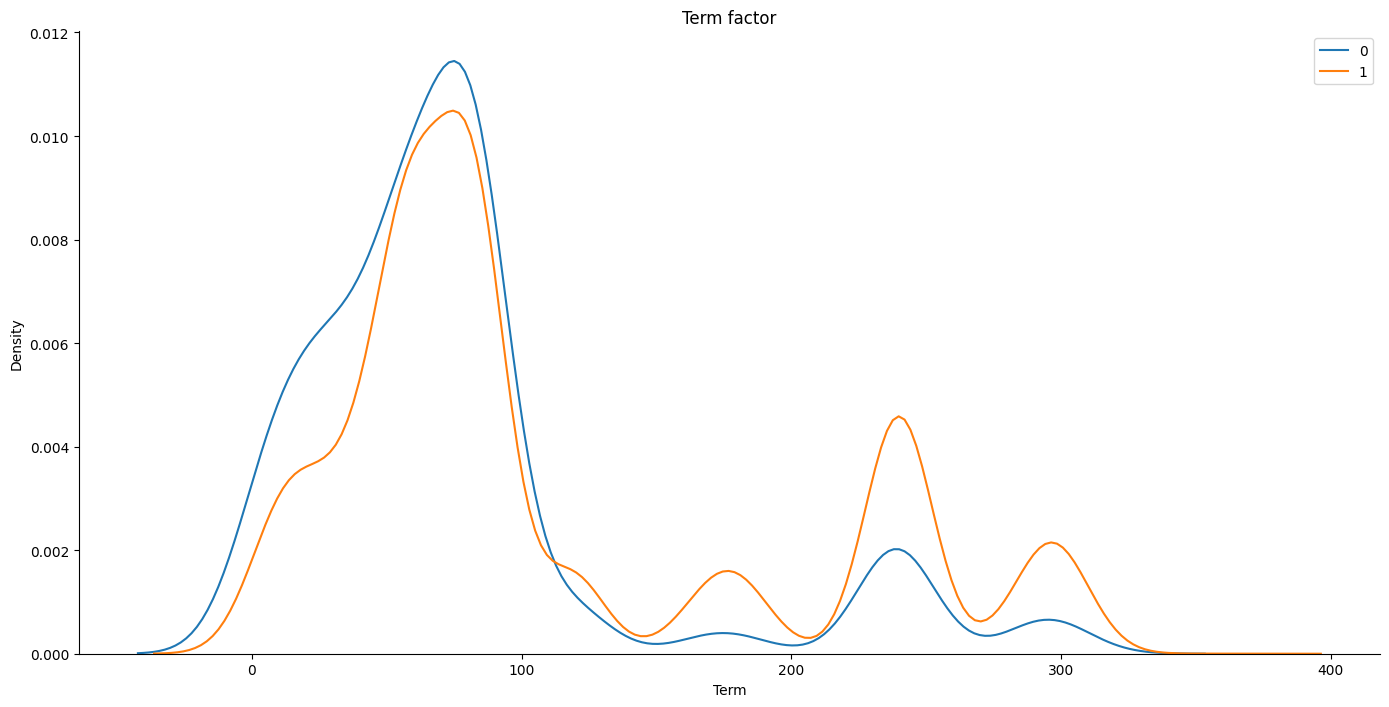

In [14]:
g = sns.FacetGrid(df_train, hue='MIS_Status', height = 7, aspect = 2)
g.map(sns.kdeplot, 'Term')
plt.legend()
plt.title('Term factor')
plt.show()

C:\Users\田代雄大\AppData\Local\Temp\ipykernel_28896\779951316.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  job_survey_data[['CreateJob', 'RetainedJob']] = np.sqrt(job_survey_data[['CreateJob', 'RetainedJob']])


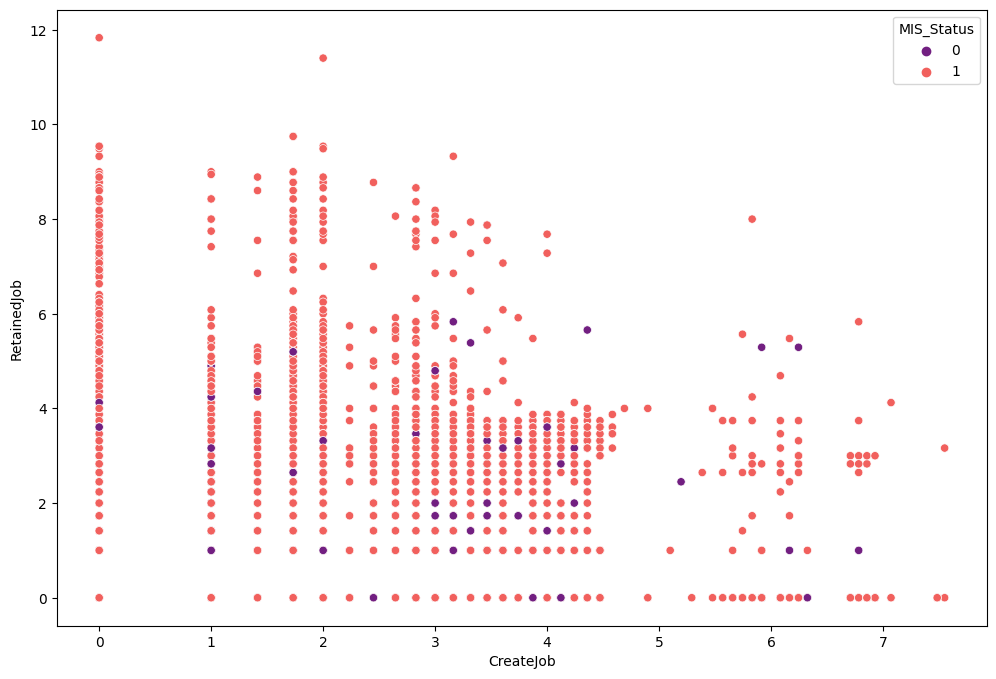

In [15]:
plt.figure(figsize = (12, 8))
job_survey_data = df_train[['CreateJob', 'RetainedJob', 'MIS_Status']]
job_survey_data[['CreateJob', 'RetainedJob']] = np.sqrt(job_survey_data[['CreateJob', 'RetainedJob']])
sns.scatterplot(data = job_survey_data, x = 'CreateJob', y = 'RetainedJob', hue = 'MIS_Status', palette = 'magma')
plt.show()
del job_survey_data

In [16]:
count = df_train['City'].value_counts()
print(f'Unique values: {len(count)}')
count_f = count[count>500]
more_popular_Cities = set(count_f.index)
print(f'Unique values after values grouped: {len(count_f)}')
count_f

Unique values: 2118
Unique values after values grouped: 1


HOUSTON    581
Name: City, dtype: int64

In [17]:
count = df_train['BankState'].value_counts()
print(f'Unique values: {len(count)}')
count_f = count[count>500]
more_popular_Banks = set(count_f.index)
print(f'Unique values after values grouped: {len(count_f)}')
count_f

Unique values: 51
Unique values after values grouped: 10


CA    3124
NC    1687
IL    1422
OH    1367
RI    1252
SD    1156
TX    1150
NY    1056
PA     632
UT     569
Name: BankState, dtype: int64

Looks like this column is better to ignore at all

In [19]:
count = df_train['Sector'].value_counts()
print(f'Unique values: {len(count)}')
count_f = count[count>500]
more_popular_NAICS = set(count_f.index)
print(f'Unique values after values grouped: {len(count_f)}')
count_f

Unique values: 24
Unique values after values grouped: 9


0     4722
42    3541
33    2500
23    1882
44    1849
72    1266
61    1238
22     980
62     592
Name: Sector, dtype: int64

# Data preparation

In [20]:
def unknown_filling_text(val):
    if pd.isna(val):
        return 'no data'
    else:
        return str(val)
    
def proc_col_City(val):
    if val not in more_popular_Cities:
        return 'other'
    else:
        return val
    
def proc_col_Bank(val):
    if val not in more_popular_Banks:
        return 'other'
    else:
        return val
    
def proc_col_NAICS(val):
    if val not in more_popular_NAICS:
        return str(val)[:3]
    else:
        return str(val)

    
def check_na(df):
    if len(df[df.isnull().any(axis=1)])!= 0:
        raise ValueError('N\A in data')
    
def pre_dumm_proc(df):
    df = df.copy()
    to_drop = [
         'ApprovalDate',
        'ApprovalFY', 'DisbursementDate', 'DisbursementGross',
        'GrAppv', 'SBA_Appv'
    ]
    df.drop(columns = to_drop, axis = 1, inplace = True)
    
    df['City'] = df['City'].apply(proc_col_City)
    df['State'] = df['State'].apply(unknown_filling_text)
    df['BankState'] = df['BankState'].apply(unknown_filling_text)
    df['Sector'] = df['Sector'].apply(proc_col_NAICS)
    df['NewExist'] = df['NewExist'].apply(unknown_filling_text)
    df['RevLineCr'] = df['RevLineCr'].apply(unknown_filling_text)
    df['LowDoc'] = df['LowDoc'].apply(unknown_filling_text)
    check_na(df)
    return df

def dummification(df):
    dummy_df = pd.DataFrame()
    object_cols = df.columns[df.dtypes == object]
    for col in object_cols:
        dummy_df = pd.concat([dummy_df, create_dummy(col, df)], axis = 1)
    
    df_out = pd.concat([df.drop(columns = object_cols), dummy_df], axis = 1)
    return df_out.sort_index(ascending=False, axis=1)
        

def create_dummy(col, df):
    df_dummy = pd.get_dummies(df[col], drop_first = True)
    df_dummy.columns = ['dum: ' + col + ': ' + str(name) for name in df_dummy.columns]
    return df_dummy

def data_preparation(df):
    return dummification(pre_dumm_proc(df))

df_train_d = data_preparation(df_train)
df_train_c = pre_dumm_proc(df_train)
df_train_d

dum: State: WY  dum: State: WV  dum: State: WI  dum: State: WA  \
24039               0               0               0               0   
27293               0               0               0               0   
700                 0               0               0               0   
28031               0               0               0               0   
8265                0               0               0               0   
...               ...             ...             ...             ...   
28111               0               0               0               0   
38101               0               0               0               0   
38343               0               0               0               0   
6293                0               0               0               0   
26779               0               0               0               0   

       dum: State: VT  dum: State: VA  dum: State: UT  dum: State: TX  \
24039               0               0               0               0   
27293               0               0               0               0   
700                 0               0               0               1   
28031               0               0               0               0   
8265                0               0               0               0   
...               ...             ...             ...             ...   
28111               0               0               0               0   
38101               0               0               0               0   
38343               0               0               0               1   
6293                0               0               0               0   
26779               0               0               0               0   

       dum: State: TN  dum: State: SD  dum: State: SC  dum: State: RI  \
24039               0               0               0               0   
27293               0               0               0               0   
700                 0               0               0               0   
28031               0               0               0               0   
8265                0               0               0               0   
...               ...             ...             ...             ...   
28111               0               0               0               0   
38101               0               0               0               0   
38343               0               0               0               0   
6293                0               0               0               0   
26779               0               0               0               0   

       dum: State: PA  dum: State: OR  dum: State: OK  dum: State: OH  \
24039               0               0               0               0   
27293               0               0               0               0   
700                 0               0               0               0   
28031               0               0               0               0   
8265                0               0               0               0   
...               ...             ...             ...             ...   
28111               1               0               0               0   
38101               0               0               0               0   
38343               0               0               0               0   
6293                0               0               0               0   
26779               0               0               0               0   

       dum: State: NY  dum: State: NV  dum: State: NM  dum: State: NJ  \
24039               0               0               0               0   
27293               0               0               0               0   
700                 0               0               0               0   
28031               0               0               0               0   
8265                0               0               0               0   
...               ...             ...             ...        

In [21]:
df_train_c

Unnamed: 0  Term  NoEmp NewExist  CreateJob  RetainedJob  \
24039       24039   239     37      1.0          4            0   
27293       27293   240     17      1.0          6            0   
700           700   179      7      1.0          0            0   
28031       28031   235      3      1.0          0            0   
8265         8265    57      7      1.0          0            0   
...           ...   ...    ...      ...        ...          ...   
28111       28111    82      4      1.0         10            1   
38101       38101   242     21      1.0          0            0   
38343       38343    59      4      1.0          0            0   
6293         6293    84      4      1.0          0            6   
26779       26779   171     17      2.0          0            0   

       FranchiseCode RevLineCr LowDoc  MIS_Status Sector     City State  \
24039              1         N      N           1     72    other    MA   
27293              0         N      N           1     33    other    MA   
700              960         N      Y           1      0  HOUSTON    TX   
28031              1         N      N           1     44    other    CA   
8265               1         N      N           1     42    other    NE   
...              ...       ...    ...         ...    ...      ...   ...   
28111              0         Y      N           0     33    other    PA   
38101              0         N      N           1     61    other    IL   
38343              0         N      N           1      0    other    TX   
6293               0         N      N           1     42    other    MO   
26779              1         N      N           1      0    other    CA   

      BankState  UrbanRural  
24039        RI           2  
27293        RI           0  
700          TX           0  
28031        CA           1  
8265         NE           0  
...         ...         ...  
28111        PA           2  
38101        IL           0  
38343        TX           0  
6293         MO           2  
26779        SD           0  

[20624 rows x 15 columns]

In [22]:
columns_needed = set(df_train_d.columns)

def columns_standardization(df):
    df = df.copy()
    for col in columns_needed:
        if col not in set(df.columns):
            df.insert(loc = len(df.columns), column = col, value = 0, allow_duplicates=False)
    
    for col in set(df.columns):
        if col not in columns_needed:
            df.drop(columns = col, axis = 1, inplace = True)
    
    return df.sort_index(ascending=False, axis=1)

In [23]:
df_test_d = columns_standardization(data_preparation(df_test))
df_test_c = pre_dumm_proc(df_test)
df_test_d

dum: State: WY  dum: State: WV  dum: State: WI  dum: State: WA  \
11775               0               0               0               0   
33192               0               0               0               0   
9621                0               0               0               0   
9173                0               0               0               0   
1598                0               0               0               0   
...               ...             ...             ...             ...   
39947               0               0               1               0   
12088               0               0               0               0   
15398               0               0               0               0   
39478               0               0               0               0   
35316               0               0               0               0   

       dum: State: VT  dum: State: VA  dum: State: UT  dum: State: TX  \
11775               0               0               0               0   
33192               0               0               0               0   
9621                0               0               0               0   
9173                0               0               0               0   
1598                0               0               0               0   
...               ...             ...             ...             ...   
39947               0               0               0               0   
12088               0               0               0               0   
15398               0               0               0               0   
39478               0               0               0               0   
35316               0               0               0               0   

       dum: State: TN  dum: State: SD  dum: State: SC  dum: State: RI  \
11775               0               0               0               0   
33192               0               0               0               0   
9621                0               0               0               0   
9173                0               0               0               0   
1598                0               0               0               0   
...               ...             ...             ...             ...   
39947               0               0               0               0   
12088               0               0               0               0   
15398               0               0               0               0   
39478               0               0               0               0   
35316               0               0               0               0   

       dum: State: PA  dum: State: OR  dum: State: OK  dum: State: OH  \
11775               0               0               0               0   
33192               0               0               0               0   
9621                0               0               0               0   
9173                0               0               0               0   
1598                0               0               0               0   
...               ...             ...             ...             ...   
39947               0               0               0               0   
12088               0               0               0               0   
15398               0               0               0               0   
39478               0               0               0               0   
35316               0               0               0               1   

       dum: State: NY  dum: State: NV  dum: State: NM  dum: State: NJ  \
11775               0               0               0               0   
33192               0               0               0               0   
9621                0               0               0               0   
9173                0               0               0               0   
1598                0               0               0               0   
...               ...             ...             ...        

In [24]:
df_test_c.head()

Unnamed: 0  Term  NoEmp NewExist  CreateJob  RetainedJob  \
11775       11775     8     13      1.0          0            0   
33192       33192    37      6      2.0          0            0   
9621         9621    44      1      2.0          0            1   
9173         9173   175      8      1.0          0            0   
1598         1598    38      3      1.0          0            1   

       FranchiseCode RevLineCr LowDoc  MIS_Status Sector   City State  \
11775              1         N      N           1      0  other    MO   
33192              0         N      N           0     71  other    AZ   
9621               0         N      N           1     45  other    NC   
9173               0         N      N           1      0  other    IA   
1598               1         0      N           1     56  other    ID   

      BankState  UrbanRural  
11775        MO           0  
33192        AZ           0  
9621         NC           0  
9173         IA           0  
1598         WA           1

In [25]:
df_test_d[df_test_d.isnull().any(axis=1)]

Empty DataFrame
Columns: [dum: State: WY, dum: State: WV, dum: State: WI, dum: State: WA, dum: State: VT, dum: State: VA, dum: State: UT, dum: State: TX, dum: State: TN, dum: State: SD, dum: State: SC, dum: State: RI, dum: State: PA, dum: State: OR, dum: State: OK, dum: State: OH, dum: State: NY, dum: State: NV, dum: State: NM, dum: State: NJ, dum: State: NH, dum: State: NE, dum: State: ND, dum: State: NC, dum: State: MT, dum: State: MS, dum: State: MO, dum: State: MN, dum: State: MI, dum: State: ME, dum: State: MD, dum: State: MA, dum: State: LA, dum: State: KY, dum: State: KS, dum: State: IN, dum: State: IL, dum: State: ID, dum: State: IA, dum: State: HI, dum: State: GA, dum: State: FL, dum: State: DE, dum: State: DC, dum: State: CT, dum: State: CO, dum: State: CA, dum: State: AZ, dum: State: AR, dum: State: AL, dum: Sector: 81, dum: Sector: 72, dum: Sector: 71, dum: Sector: 62, dum: Sector: 61, dum: Sector: 56, dum: Sector: 55, dum: Sector: 54, dum: Sector: 53, dum: Sector: 52, dum: Sector: 51, dum: Sector: 49, dum: Sector: 48, dum: Sector: 45, dum: Sector: 44, dum: Sector: 42, dum: Sector: 33, dum: Sector: 32, dum: Sector: 31, dum: Sector: 23, dum: Sector: 22, dum: Sector: 21, dum: Sector: 11, dum: RevLineCr: no data, dum: RevLineCr: Y, dum: RevLineCr: T, dum: RevLineCr: N, dum: NewExist: 2.0, dum: LowDoc: no data, dum: LowDoc: Y, dum: LowDoc: S, dum: LowDoc: N, dum: LowDoc: C, dum: LowDoc: A, dum: City: other, dum: BankState: no data, dum: BankState: WY, dum: BankState: WV, dum: BankState: WI, dum: BankState: WA, dum: BankState: VT, dum: BankState: VA, dum: BankState: UT, dum: BankState: TX, dum: BankState: TN, dum: BankState: SD, dum: BankState: SC, dum: BankState: RI, dum: BankState: PA, dum: BankState: OR, ...]
Index: []

In [26]:
df_train_d[df_train_d.isnull().any(axis=1)]

Empty DataFrame
Columns: [dum: State: WY, dum: State: WV, dum: State: WI, dum: State: WA, dum: State: VT, dum: State: VA, dum: State: UT, dum: State: TX, dum: State: TN, dum: State: SD, dum: State: SC, dum: State: RI, dum: State: PA, dum: State: OR, dum: State: OK, dum: State: OH, dum: State: NY, dum: State: NV, dum: State: NM, dum: State: NJ, dum: State: NH, dum: State: NE, dum: State: ND, dum: State: NC, dum: State: MT, dum: State: MS, dum: State: MO, dum: State: MN, dum: State: MI, dum: State: ME, dum: State: MD, dum: State: MA, dum: State: LA, dum: State: KY, dum: State: KS, dum: State: IN, dum: State: IL, dum: State: ID, dum: State: IA, dum: State: HI, dum: State: GA, dum: State: FL, dum: State: DE, dum: State: DC, dum: State: CT, dum: State: CO, dum: State: CA, dum: State: AZ, dum: State: AR, dum: State: AL, dum: Sector: 81, dum: Sector: 72, dum: Sector: 71, dum: Sector: 62, dum: Sector: 61, dum: Sector: 56, dum: Sector: 55, dum: Sector: 54, dum: Sector: 53, dum: Sector: 52, dum: Sector: 51, dum: Sector: 49, dum: Sector: 48, dum: Sector: 45, dum: Sector: 44, dum: Sector: 42, dum: Sector: 33, dum: Sector: 32, dum: Sector: 31, dum: Sector: 23, dum: Sector: 22, dum: Sector: 21, dum: Sector: 11, dum: RevLineCr: no data, dum: RevLineCr: Y, dum: RevLineCr: T, dum: RevLineCr: N, dum: NewExist: 2.0, dum: LowDoc: no data, dum: LowDoc: Y, dum: LowDoc: S, dum: LowDoc: N, dum: LowDoc: C, dum: LowDoc: A, dum: City: other, dum: BankState: no data, dum: BankState: WY, dum: BankState: WV, dum: BankState: WI, dum: BankState: WA, dum: BankState: VT, dum: BankState: VA, dum: BankState: UT, dum: BankState: TX, dum: BankState: TN, dum: BankState: SD, dum: BankState: SC, dum: BankState: RI, dum: BankState: PA, dum: BankState: OR, ...]
Index: []

No null value left

In [27]:
X_train = df_train_d.drop('MIS_Status', axis = 1)
y_train = df_train_d['MIS_Status']
X_test = df_test_d.drop('MIS_Status', axis = 1)
y_test = df_test_d['MIS_Status']

In [28]:
del df, df_train_d, df_train_c, df_test_d, df_test_c

In [29]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train.values)
X_test_sc = scaler.transform(X_test.values)

c:\Users\田代雄大\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\田代雄大\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


# Dimensionality reduction using PCA

In [30]:
pca = PCA(n_components=2, random_state = 1)
df_pca_train = pca.fit_transform(X_train_sc)
df_pca_test = pca.transform(X_test_sc)

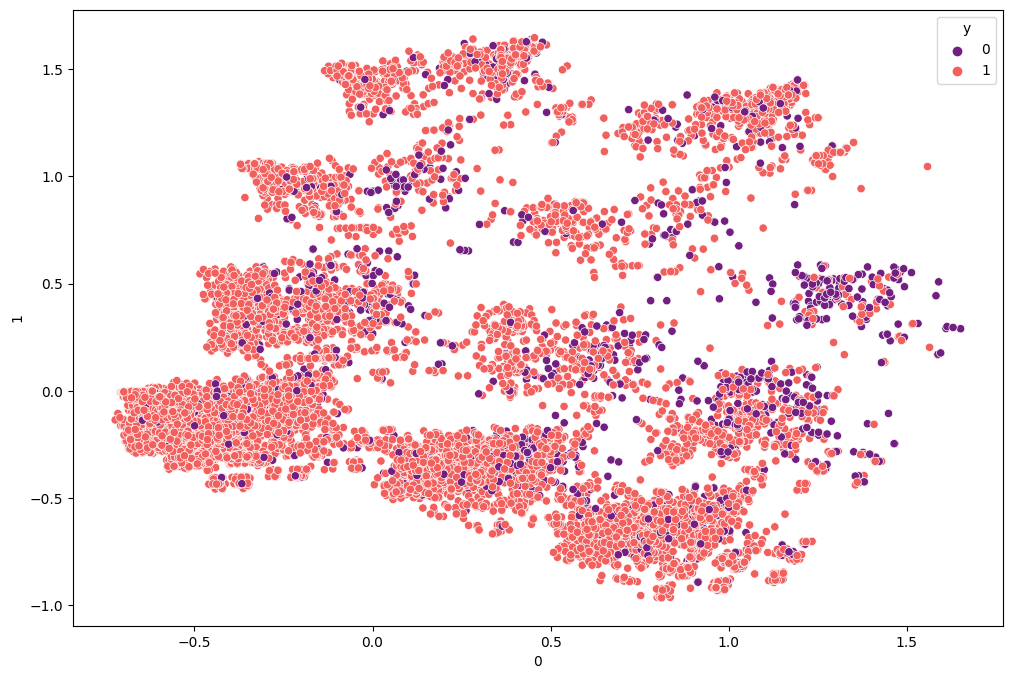

In [31]:
df_pca_vis = pd.DataFrame(df_pca_train)
df_pca_vis['y'] = y_train.values

plt.figure(figsize = (12, 8))
sns.scatterplot(data = df_pca_vis, x = 0, y = 1, hue = 'y',  palette = 'magma')
plt.show()

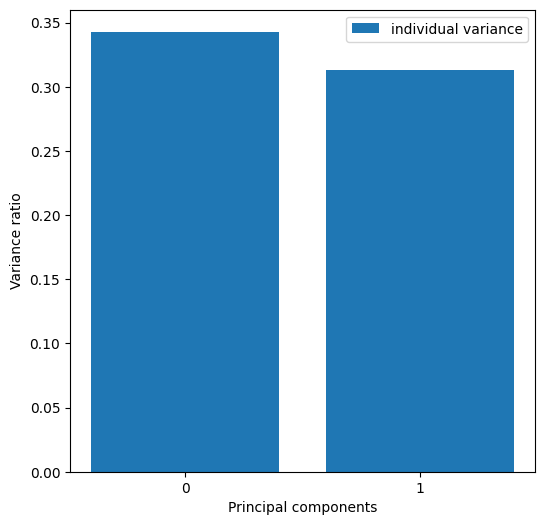

In [32]:
pca_variance = pca.explained_variance_

plt.figure(figsize=(6, 6))
plt.bar(['0', '1'], pca_variance, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

In [33]:
lgbr_pca = LGBMClassifier(random_state = 1, n_jobs=- 1)
lgbr_pca.fit(df_pca_train, y_train)
pred = lgbr_pca.predict(df_pca_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.61      0.09      0.16       702
           1       0.91      0.99      0.95      6173

    accuracy                           0.90      6875
   macro avg       0.76      0.54      0.55      6875
weighted avg       0.88      0.90      0.87      6875

[[  64  638]
 [  41 6132]]


# Dimensionality reduction using Singular Value Decomposition

In [34]:
svd = TruncatedSVD(n_components=2, random_state = 1)
df_svd_train = svd.fit_transform(X_train_sc)
df_svd_test = svd.transform(X_test_sc)

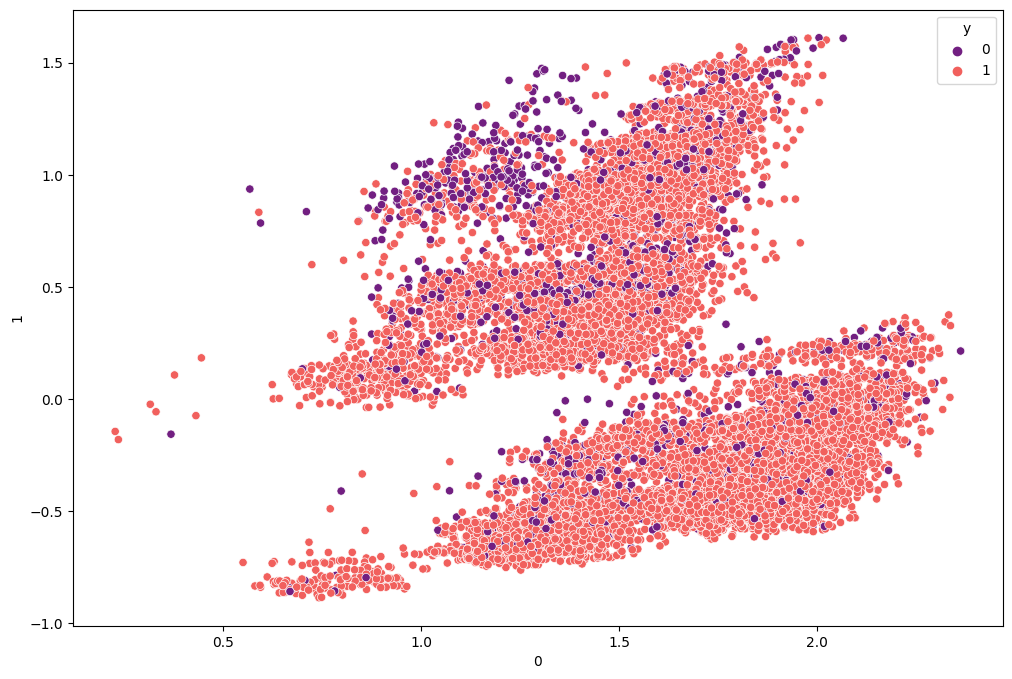

In [35]:
df_svd_vis = pd.DataFrame(df_svd_train)
df_svd_vis['y'] = y_train.values

plt.figure(figsize = (12, 8))
sns.scatterplot(data = df_svd_vis, x = 0, y = 1, hue = 'y',  palette = 'magma')
plt.show()

In [36]:
lgbr_svd = LGBMClassifier(random_state = 1, n_jobs=- 1)
lgbr_svd.fit(df_svd_train, y_train)
pred = lgbr_svd.predict(df_svd_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.55      0.07      0.13       702
           1       0.90      0.99      0.95      6173

    accuracy                           0.90      6875
   macro avg       0.73      0.53      0.54      6875
weighted avg       0.87      0.90      0.86      6875

[[  52  650]
 [  42 6131]]


# Dimensionality reduction using Non-Negative Matrix Factorization (NMF)

In [37]:
nmf = NMF(n_components=2, random_state = 1)
df_nmf_train = nmf.fit_transform(X_train_sc, y_train)
df_nmf_test = nmf.transform(X_test_sc)

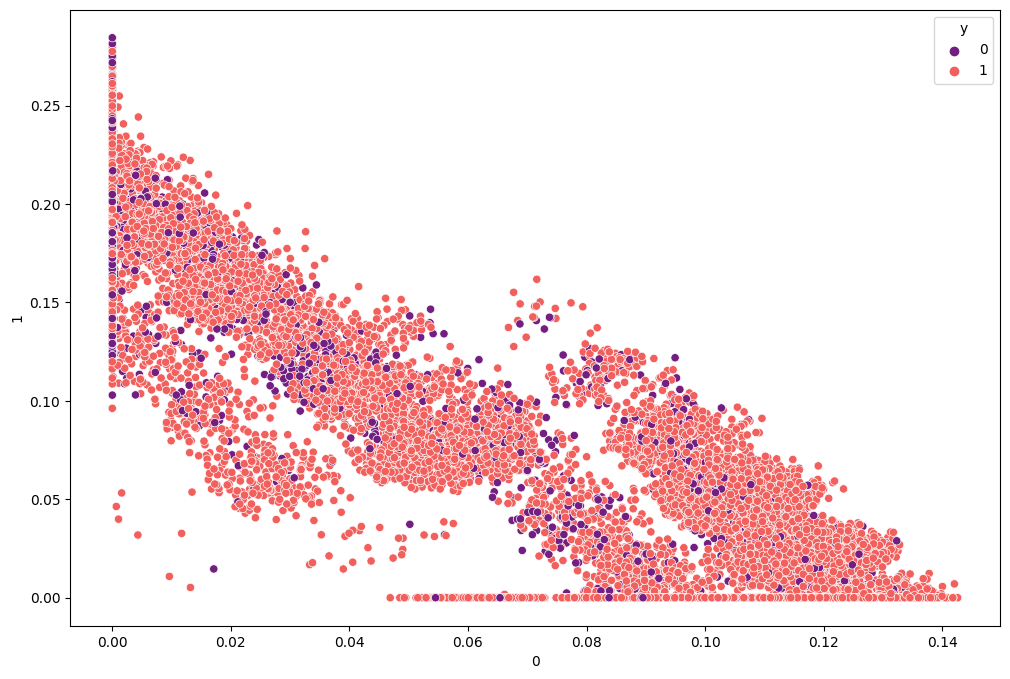

In [38]:
df_nmf_vis = pd.DataFrame(df_nmf_train)
df_nmf_vis['y'] = y_train.values

plt.figure(figsize = (12, 8))
sns.scatterplot(data = df_nmf_vis, x = 0, y = 1, hue = 'y',  palette = 'magma')
plt.show()

In [39]:
lgbr_nmf = LGBMClassifier(random_state = 1, n_jobs=- 1)
lgbr_nmf.fit(df_nmf_train, y_train)
pred = lgbr_nmf.predict(df_nmf_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.18      0.00      0.01       702
           1       0.90      1.00      0.95      6173

    accuracy                           0.90      6875
   macro avg       0.54      0.50      0.48      6875
weighted avg       0.82      0.90      0.85      6875

[[   2  700]
 [   9 6164]]


# Dimensionality reduction using Linear Discriminant Analysis

In [40]:
lda = LinearDiscriminantAnalysis(n_components=1)
df_lda_train = lda.fit_transform(X_train_sc, y_train)
df_lda_test = lda.transform(X_test_sc)

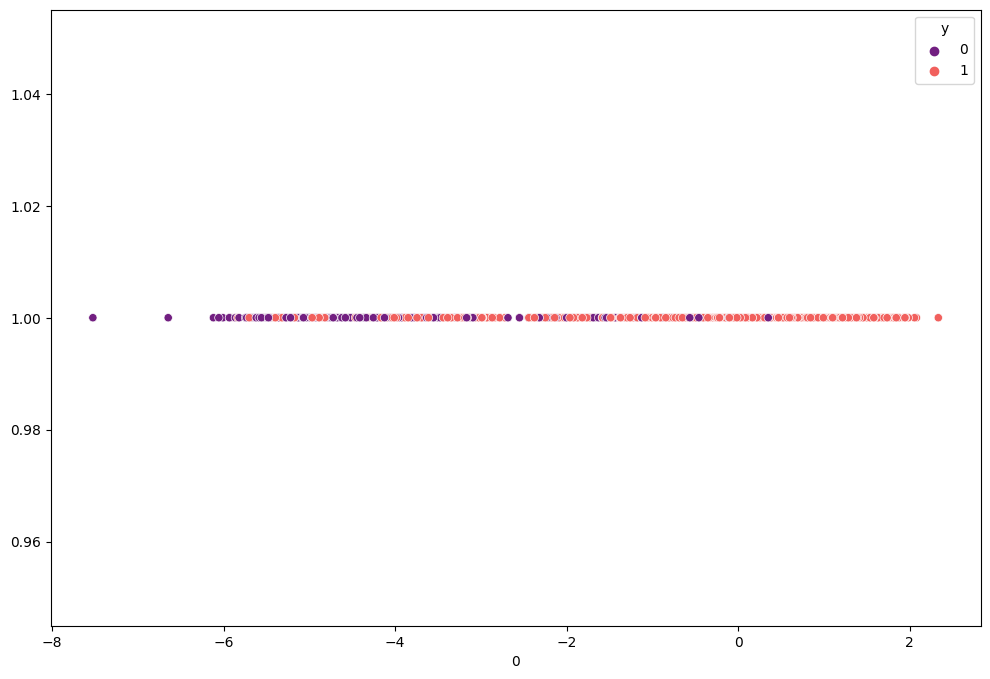

In [41]:
df_lda_vis = pd.DataFrame(df_lda_train)
df_lda_vis['y'] = y_train.values

plt.figure(figsize = (12, 8))
sns.scatterplot(data = df_lda_vis, x = 0, y = 1, hue = 'y',  palette = 'magma')
plt.show()

In [42]:
lgbr_lda = LGBMClassifier(random_state = 1, n_jobs=- 1)
lgbr_lda.fit(df_lda_train, y_train)
pred = lgbr_lda.predict(df_lda_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.68      0.20      0.31       702
           1       0.92      0.99      0.95      6173

    accuracy                           0.91      6875
   macro avg       0.80      0.60      0.63      6875
weighted avg       0.89      0.91      0.89      6875

[[ 142  560]
 [  66 6107]]


# Dimensionality reduction using autoencoder

In [43]:
input_width = len(X_train.columns)
input_width

143

In [44]:
def dim_red_analysis(n_epochs = None):
    seed(101)
    set_seed(101)

    encoder = Sequential()
    encoder.add(Dense(units = 256, activation = 'relu', input_shape = [input_width]))
    encoder.add(Dropout(0.2))
    encoder.add(Dense(units = 16, activation = 'relu'))
    encoder.add(Dense(units = 2, activation = 'relu'))

    decoder = Sequential()
    decoder.add(Dense(units = 16, activation = 'relu', input_shape = [2]))
    decoder.add(Dense(units = 256, activation = 'relu'))
    decoder.add(Dense(units = input_width, activation = 'relu'))

    autoencoder = Sequential([encoder, decoder])

    autoencoder.compile(loss = 'mse', optimizer = SGD(lr = 12))
    
    autoencoder.summary()
    
    if n_epochs is None:
        es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)]
        n_epochs = 100
    else:
        es = []
    
    autoencoder.fit(
            X_train_sc,
            X_train_sc,
            epochs = n_epochs,
            validation_data=(X_test_sc, X_test_sc), 
            callbacks=[es]
             )
    
    if n_epochs > 1:
        histo = pd.DataFrame(autoencoder.history.history)
        for metric in ['loss', 'val_loss']:
            plt.title(metric)
            histo[metric].plot()
            plt.show()
        
    encoded_2dim = encoder.predict(X_train_sc)
    encoded_2dim = pd.DataFrame(encoded_2dim)
    encoded_2dim['y'] = y_train.values

    plt.figure(figsize = (12, 8))
    sns.scatterplot(data = encoded_2dim, x = 0, y = 1, hue = 'y', palette = 'magma')
    plt.show()
    
    return encoder

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 2)                 41010     
                                                                 
 sequential_1 (Sequential)   (None, 143)               41151     
                                                                 
Total params: 82,161
Trainable params: 82,161
Non-trainable params: 0
_________________________________________________________________
645/645 [==============================] - 1s 631us/step


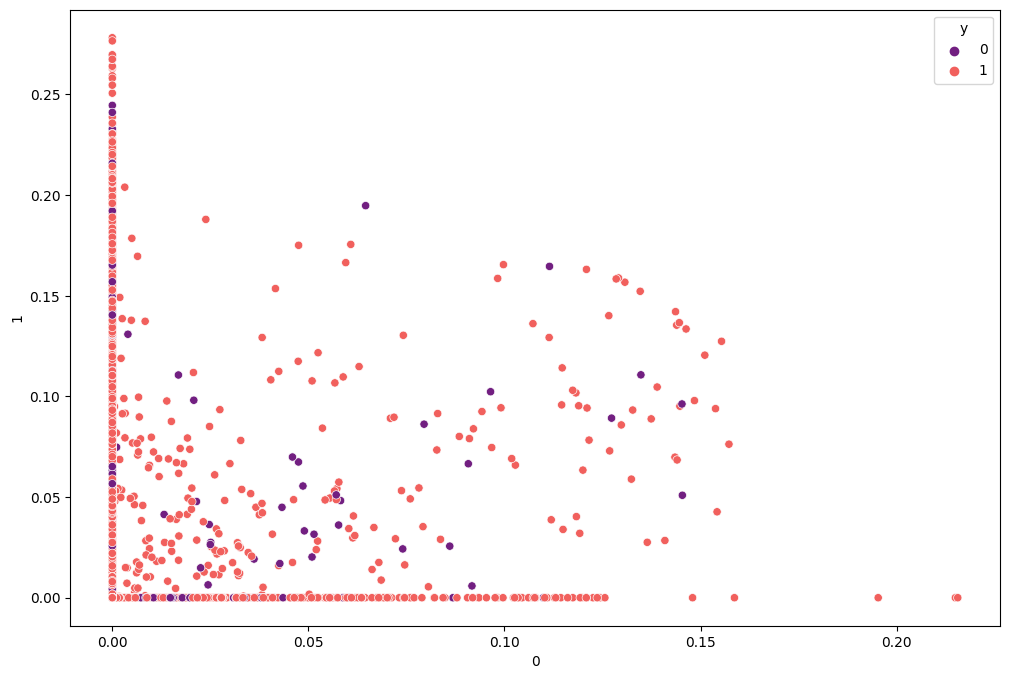

215/215 [==============================] - 0s 677us/step
              precision    recall  f1-score   support

           0       0.30      0.00      0.01       702
           1       0.90      1.00      0.95      6173

    accuracy                           0.90      6875
   macro avg       0.60      0.50      0.48      6875
weighted avg       0.84      0.90      0.85      6875

[[   3  699]
 [   7 6166]]


In [45]:
encoder = dim_red_analysis(0)

enc_train = encoder.predict(X_train_sc)
enc_test = encoder.predict(X_test_sc)

lgbr_enc = LGBMClassifier(random_state = 1, n_jobs=- 1)
lgbr_enc.fit(enc_train, y_train)
pred = lgbr_enc.predict(enc_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 2)                 41010     
                                                                 
 sequential_4 (Sequential)   (None, 143)               41151     
                                                                 
Total params: 82,161
Trainable params: 82,161
Non-trainable params: 0
_________________________________________________________________
645/645 [==============================] - 0s 617us/step


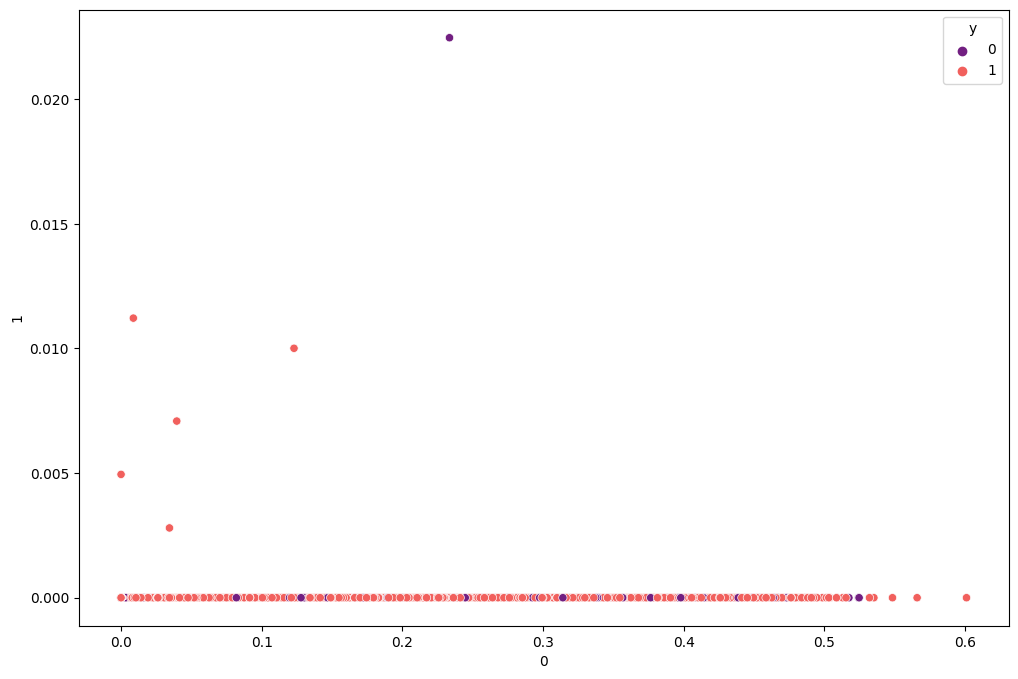

215/215 [==============================] - 0s 643us/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       702
           1       0.90      1.00      0.95      6173

    accuracy                           0.90      6875
   macro avg       0.45      0.50      0.47      6875
weighted avg       0.81      0.90      0.85      6875

[[   0  702]
 [   0 6173]]


c:\Users\田代雄大\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\田代雄大\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\田代雄大\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [46]:
encoder = dim_red_analysis(1)

enc_train = encoder.predict(X_train_sc)
enc_test = encoder.predict(X_test_sc)

lgbr_enc = LGBMClassifier(random_state = 1, n_jobs=- 1)
lgbr_enc.fit(enc_train, y_train)
pred = lgbr_enc.predict(enc_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 2)                 41010     
                                                                 
 sequential_7 (Sequential)   (None, 143)               41151     
                                                                 
Total params: 82,161
Trainable params: 82,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
645/645 [==============================] - 2s 2ms/step - loss: 0.0439 - val_loss: 0.0424
Epoch 2/2
645/645 [==============================] - 1s 2ms/step - loss: 0.0412 - val_loss: 0.0399


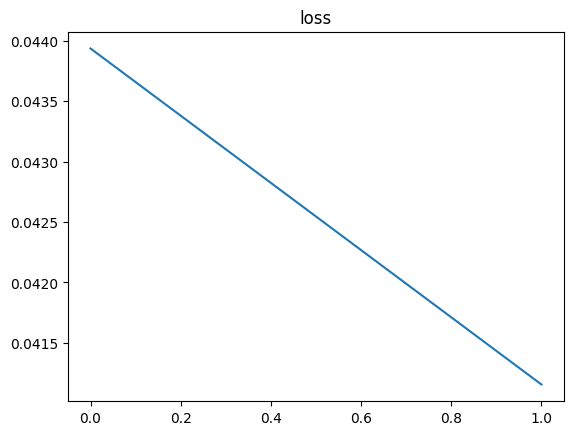

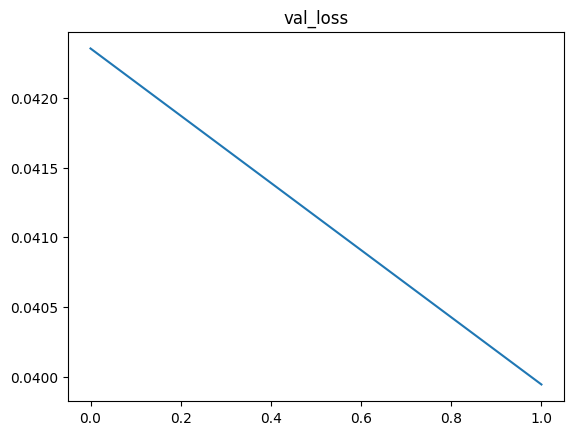

645/645 [==============================] - 0s 618us/step


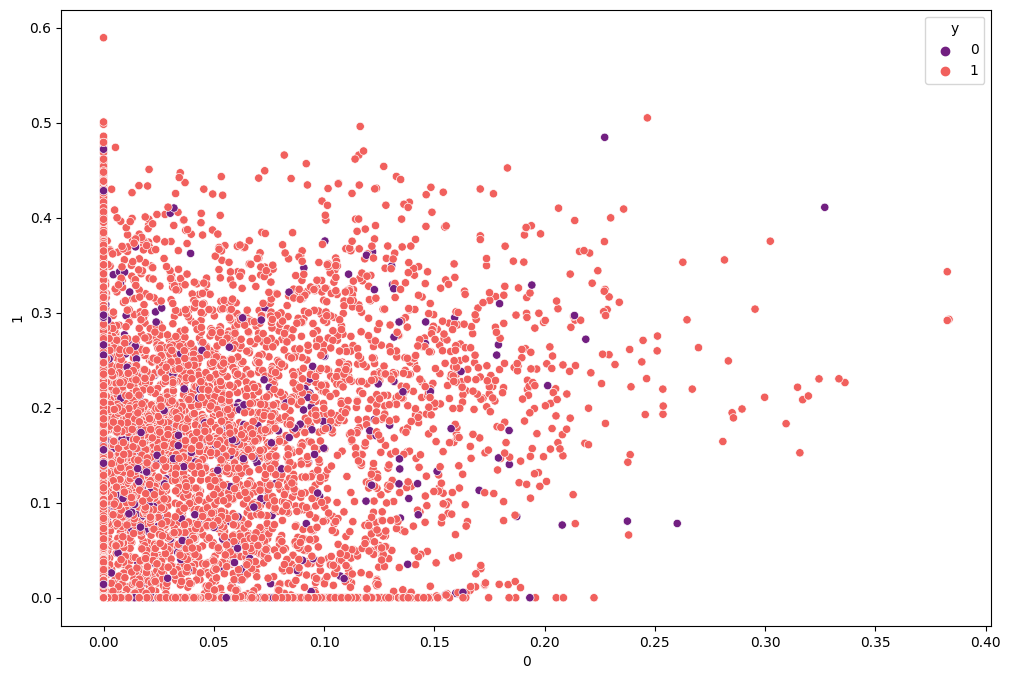

215/215 [==============================] - 0s 605us/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       702
           1       0.90      1.00      0.95      6173

    accuracy                           0.90      6875
   macro avg       0.45      0.50      0.47      6875
weighted avg       0.81      0.90      0.85      6875

[[   0  702]
 [   3 6170]]


In [47]:
encoder = dim_red_analysis(2)

enc_train = encoder.predict(X_train_sc)
enc_test = encoder.predict(X_test_sc)

lgbr_enc = LGBMClassifier(random_state = 1, n_jobs=- 1)
lgbr_enc.fit(enc_train, y_train)
pred = lgbr_enc.predict(enc_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 2)                 41010     
                                                                 
 sequential_10 (Sequential)  (None, 143)               41151     
                                                                 
Total params: 82,161
Trainable params: 82,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
645/645 [==============================] - 2s 2ms/step - loss: 0.0440 - val_loss: 0.0424
Epoch 2/5
645/645 [==============================] - 1s 2ms/step - loss: 0.0411 - val_loss: 0.0398
Epoch 3/5
645/645 [==============================] - 1s 2ms/step - loss: 0.0388 - val_loss: 0.0377
Epoch 4/5
645/645 [==============================] - 1s 2ms/step - loss: 0.0370 - val_loss: 0.0362
Epoch 5/5
645/645 [==============================

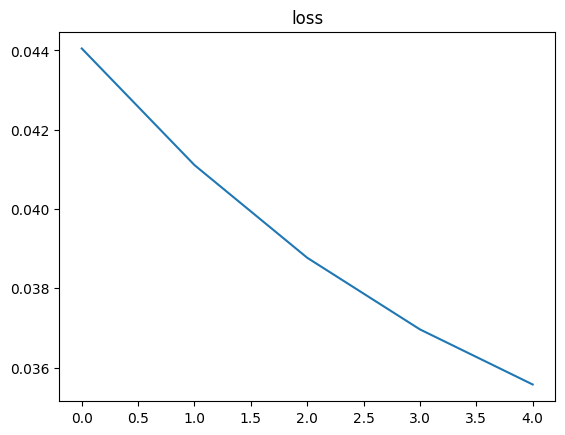

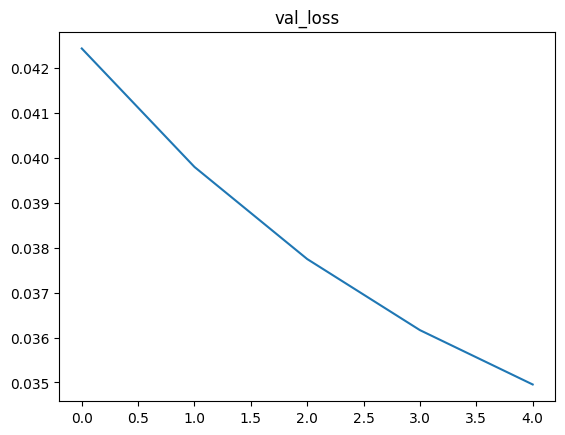

645/645 [==============================] - 0s 690us/step


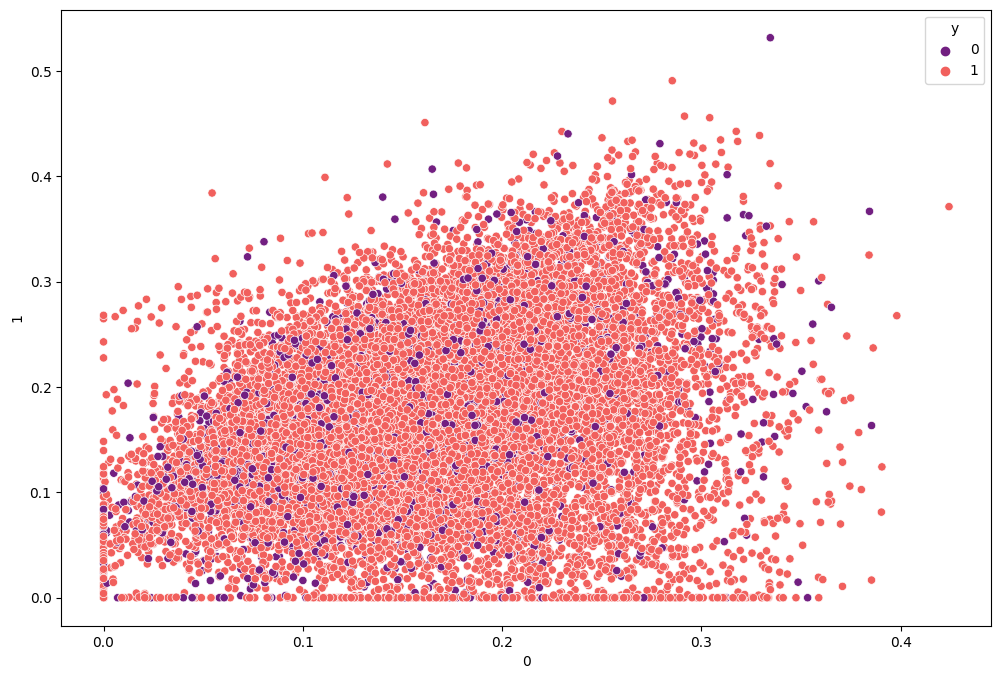

215/215 [==============================] - 0s 624us/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       702
           1       0.90      1.00      0.95      6173

    accuracy                           0.90      6875
   macro avg       0.45      0.50      0.47      6875
weighted avg       0.81      0.90      0.85      6875

[[   0  702]
 [   2 6171]]


In [48]:
encoder = dim_red_analysis(5)

enc_train = encoder.predict(X_train_sc)
enc_test = encoder.predict(X_test_sc)

lgbr_enc = LGBMClassifier(random_state = 1, n_jobs=- 1)
lgbr_enc.fit(enc_train, y_train)
pred = lgbr_enc.predict(enc_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))
del encoder, enc_train, enc_test, lgbr_enc, pred

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 2)                 41010     
                                                                 
 sequential_13 (Sequential)  (None, 143)               41151     
                                                                 
Total params: 82,161
Trainable params: 82,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
645/645 [==============================] - 2s 2ms/step - loss: 0.0432 - val_loss: 0.0409
Epoch 2/100
645/645 [==============================] - 1s 2ms/step - loss: 0.0391 - val_loss: 0.0373
Epoch 3/100
645/645 [==============================] - 1s 2ms/step - loss: 0.0359 - val_loss: 0.0345
Epoch 4/100
645/645 [==============================] - 1s 2ms/step - loss: 0.0335 - val_loss: 0.0325
Epoch 5/100
645/645 [====================

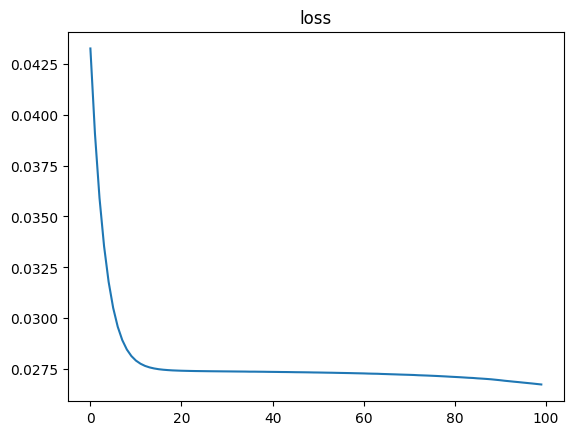

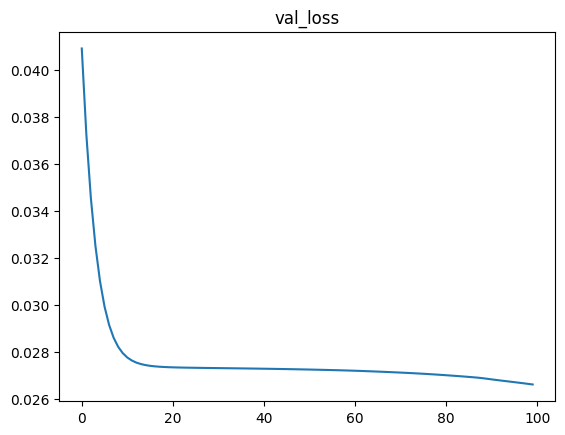

645/645 [==============================] - 0s 602us/step


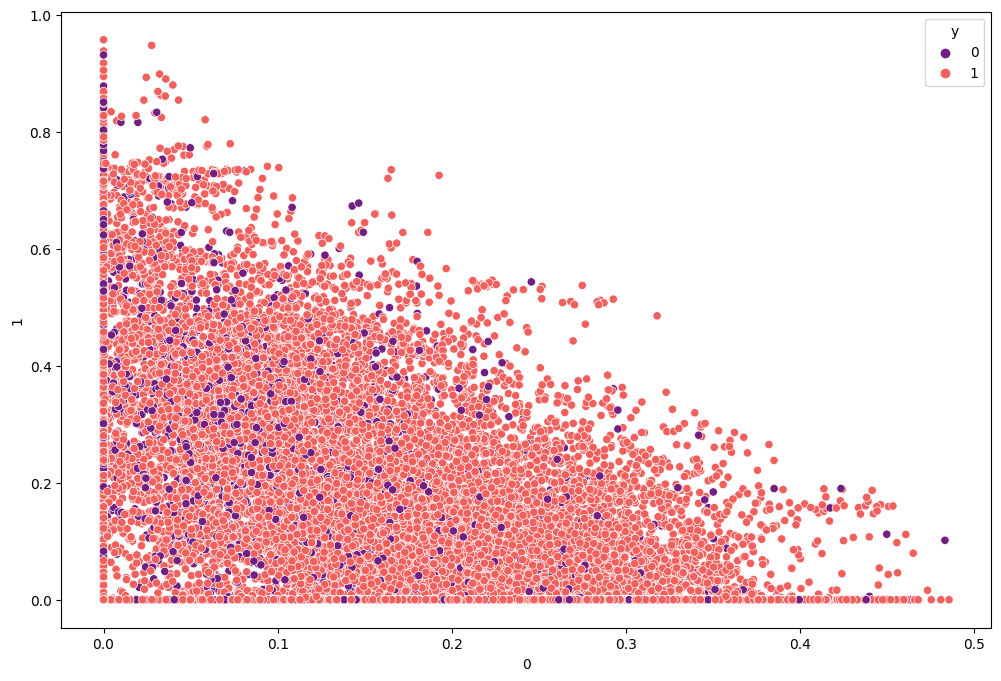

215/215 [==============================] - 0s 588us/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       702
           1       0.90      1.00      0.95      6173

    accuracy                           0.90      6875
   macro avg       0.45      0.50      0.47      6875
weighted avg       0.81      0.90      0.85      6875

[[   0  702]
 [   0 6173]]


c:\Users\田代雄大\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\田代雄大\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\田代雄大\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [49]:
encoder = dim_red_analysis()

enc_train = encoder.predict(X_train_sc)
enc_test = encoder.predict(X_test_sc)

lgbr_enc = LGBMClassifier(random_state = 1, n_jobs=- 1)
lgbr_enc.fit(enc_train, y_train)
pred = lgbr_enc.predict(enc_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

# Modelling without DR

In [50]:
dtc = DecisionTreeClassifier(random_state = 101)
dtc.fit(X_train, y_train)
pred = dtc.predict(X_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.25      0.27      0.26       702
           1       0.92      0.90      0.91      6173

    accuracy                           0.84      6875
   macro avg       0.58      0.59      0.58      6875
weighted avg       0.85      0.84      0.84      6875

[[ 192  510]
 [ 588 5585]]


In [51]:
rfc = RandomForestClassifier(random_state = 101, n_jobs = -1)
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))
display(pd.DataFrame({'Variable':X_train.columns,
              'Importance':rfc.feature_importances_}).sort_values('Importance', ascending=False).head(10))

              precision    recall  f1-score   support

           0       0.64      0.19      0.29       702
           1       0.91      0.99      0.95      6173

    accuracy                           0.91      6875
   macro avg       0.77      0.59      0.62      6875
weighted avg       0.89      0.91      0.88      6875

[[ 134  568]
 [  77 6096]]


Variable  Importance
137          Unnamed: 0    0.140793
138                Term    0.124717
140               NoEmp    0.091609
139         RetainedJob    0.053192
142           CreateJob    0.041375
136          UrbanRural    0.039246
141       FranchiseCode    0.030464
75    dum: RevLineCr: T    0.026115
80       dum: LowDoc: S    0.021732
77   dum: NewExist: 2.0    0.018132

In [52]:
gbr = GradientBoostingClassifier(random_state = 101)
gbr.fit(X_train, y_train)
pred = gbr.predict(X_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))
display(pd.DataFrame({'Variable':X_train.columns,
              'Importance':gbr.feature_importances_}).sort_values('Importance', ascending=False).head(10))

              precision    recall  f1-score   support

           0       0.66      0.20      0.30       702
           1       0.92      0.99      0.95      6173

    accuracy                           0.91      6875
   macro avg       0.79      0.59      0.63      6875
weighted avg       0.89      0.91      0.88      6875

[[ 139  563]
 [  71 6102]]


Variable  Importance
75      dum: RevLineCr: T    0.173172
80         dum: LowDoc: S    0.165733
136            UrbanRural    0.152910
140                 NoEmp    0.105297
78   dum: LowDoc: no data    0.097774
138                  Term    0.069114
142             CreateJob    0.040079
137            Unnamed: 0    0.023460
74      dum: RevLineCr: Y    0.019573
102    dum: BankState: NY    0.017567

In [53]:
lgbr = LGBMClassifier(random_state = 1, n_jobs=- 1)
lgbr.fit(X_train.values, y_train)
pred = lgbr.predict(X_test.values)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))
display(pd.DataFrame({'Variable':X_train.columns,
              'Importance':lgbr.feature_importances_}).sort_values('Importance', ascending=False).head(10))

              precision    recall  f1-score   support

           0       0.64      0.21      0.32       702
           1       0.92      0.99      0.95      6173

    accuracy                           0.91      6875
   macro avg       0.78      0.60      0.63      6875
weighted avg       0.89      0.91      0.89      6875

[[ 148  554]
 [  85 6088]]


Variable  Importance
137         Unnamed: 0         554
138               Term         507
140              NoEmp         337
139        RetainedJob         214
142          CreateJob         187
136         UrbanRural          91
141      FranchiseCode          84
74   dum: RevLineCr: Y          50
76   dum: RevLineCr: N          47
75   dum: RevLineCr: T          38

In [54]:
xgbr = XGBClassifier(random_state = 1, n_jobs=- 1)
xgbr.fit(X_train, y_train)
pred = xgbr.predict(X_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))
display(pd.DataFrame({'Variable':X_train.columns,
              'Importance':xgbr.feature_importances_}).sort_values('Importance', ascending=False).head(10))

              precision    recall  f1-score   support

           0       0.61      0.20      0.30       702
           1       0.92      0.99      0.95      6173

    accuracy                           0.91      6875
   macro avg       0.76      0.59      0.62      6875
weighted avg       0.88      0.91      0.88      6875

[[ 139  563]
 [  88 6085]]


Variable  Importance
78   dum: LowDoc: no data    0.120539
80         dum: LowDoc: S    0.100597
75      dum: RevLineCr: T    0.077847
136            UrbanRural    0.033947
83         dum: LowDoc: A    0.017864
86     dum: BankState: WY    0.014229
102    dum: BankState: NY    0.013207
118    dum: BankState: LA    0.012315
107    dum: BankState: NE    0.011450
115    dum: BankState: ME    0.011400

In [55]:
def ANN_model_classification(model, X_train_sc, y_train, X_test_sc, y_test):
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    
    model.fit(
        x = X_train_sc,
        y = y_train,
        epochs = 100,
        validation_data=(X_test_sc, y_test), 
        batch_size = 128,
        callbacks=[es]
             )


    histo = pd.DataFrame(model.history.history)
    
    for metric in ['loss', 'val_loss', 'accuracy', 'val_accuracy']:
        plt.title(metric)
        histo[metric].plot()
        plt.show()
    
    pred_test_values = model.predict_classes(X_test_sc)

    print('test')
    print(classification_report(y_test,pred_test_values))
    print(confusion_matrix(y_test,pred_test_values))
    
    return model

Epoch 1/100
162/162 [==============================] - 1s 3ms/step - loss: 0.3454 - accuracy: 0.8908 - val_loss: 0.2876 - val_accuracy: 0.9007
Epoch 2/100
162/162 [==============================] - 0s 2ms/step - loss: 0.2972 - accuracy: 0.8989 - val_loss: 0.2793 - val_accuracy: 0.9060
Epoch 3/100
162/162 [==============================] - 0s 2ms/step - loss: 0.2919 - accuracy: 0.9019 - val_loss: 0.2772 - val_accuracy: 0.9087
Epoch 4/100
162/162 [==============================] - 0s 2ms/step - loss: 0.2891 - accuracy: 0.9034 - val_loss: 0.2769 - val_accuracy: 0.9087
Epoch 5/100
162/162 [==============================] - 0s 2ms/step - loss: 0.2880 - accuracy: 0.9032 - val_loss: 0.2767 - val_accuracy: 0.9092
Epoch 6/100
162/162 [==============================] - 0s 2ms/step - loss: 0.2872 - accuracy: 0.9037 - val_loss: 0.2768 - val_accuracy: 0.9094
Epoch 7/100
162/162 [==============================] - 0s 2ms/step - loss: 0.2849 - accuracy: 0.9044 - val_loss: 0.2783 - val_accuracy: 0.9092

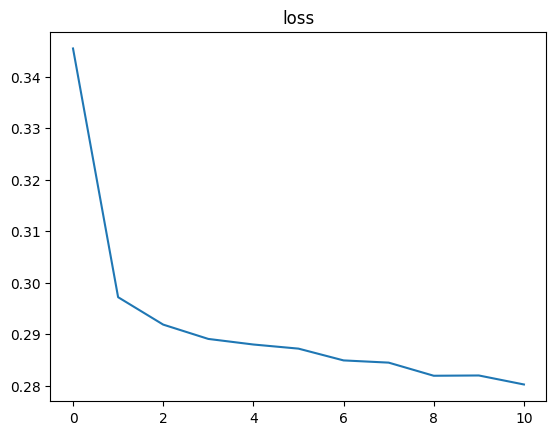

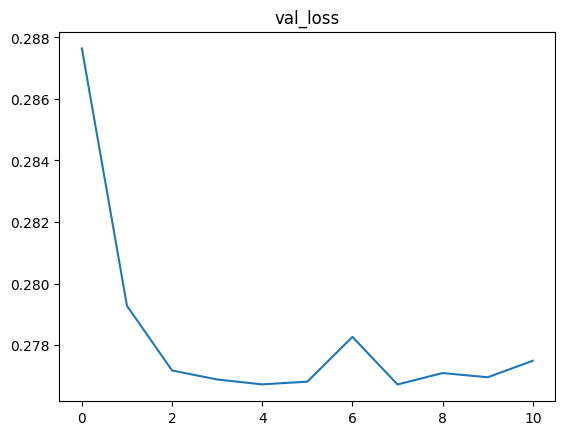

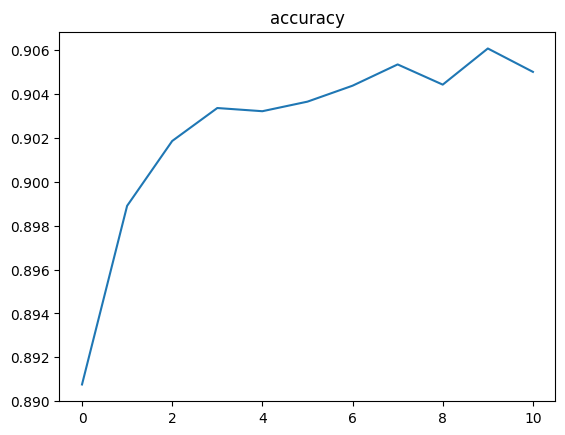

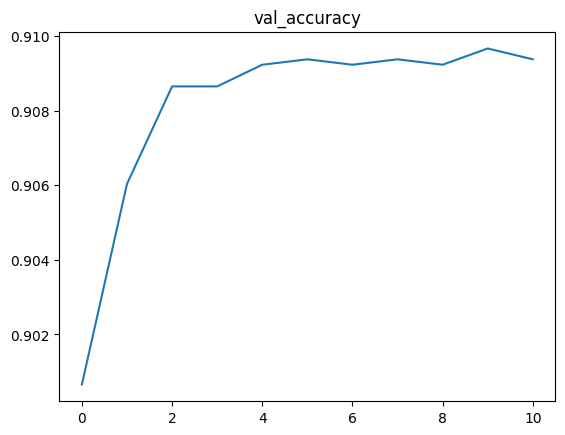

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [56]:
seed(101)
set_seed(101)

ann_model1 = Sequential()

ann_model1.add(Dense(units=128, activation = 'relu'))
ann_model1.add(Dropout(0.3))
ann_model1.add(Dense(units=1,activation='sigmoid'))
ann_model1 = ANN_model_classification(ann_model1, X_train_sc, y_train, X_test_sc, y_test)

Epoch 1/100
162/162 [==============================] - 1s 3ms/step - loss: 0.3343 - accuracy: 0.8921 - val_loss: 0.2882 - val_accuracy: 0.9007
Epoch 2/100
162/162 [==============================] - 0s 2ms/step - loss: 0.2973 - accuracy: 0.8965 - val_loss: 0.2791 - val_accuracy: 0.9062
Epoch 3/100
162/162 [==============================] - 0s 2ms/step - loss: 0.2921 - accuracy: 0.9031 - val_loss: 0.2778 - val_accuracy: 0.9087
Epoch 4/100
162/162 [==============================] - 0s 2ms/step - loss: 0.2887 - accuracy: 0.9034 - val_loss: 0.2770 - val_accuracy: 0.9089
Epoch 5/100
162/162 [==============================] - 0s 3ms/step - loss: 0.2850 - accuracy: 0.9038 - val_loss: 0.2774 - val_accuracy: 0.9084
Epoch 6/100
162/162 [==============================] - 0s 3ms/step - loss: 0.2838 - accuracy: 0.9049 - val_loss: 0.2777 - val_accuracy: 0.9089
Epoch 7/100
162/162 [==============================] - 0s 2ms/step - loss: 0.2823 - accuracy: 0.9049 - val_loss: 0.2799 - val_accuracy: 0.9085

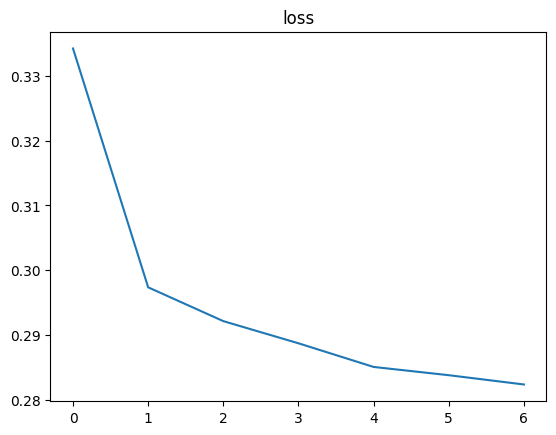

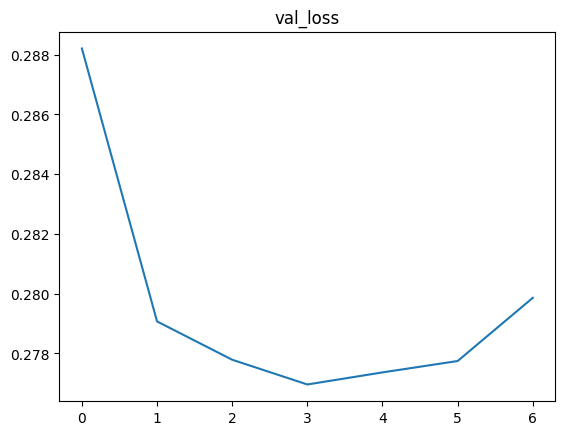

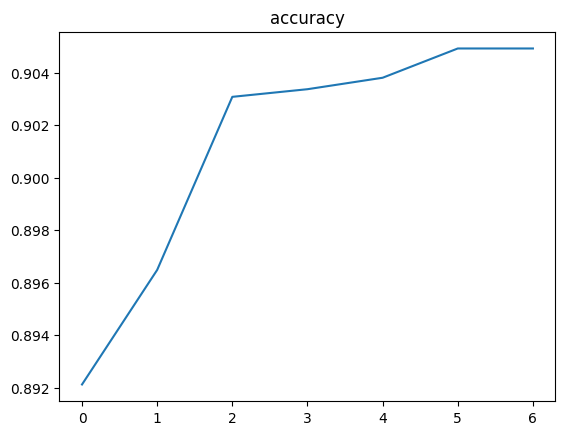

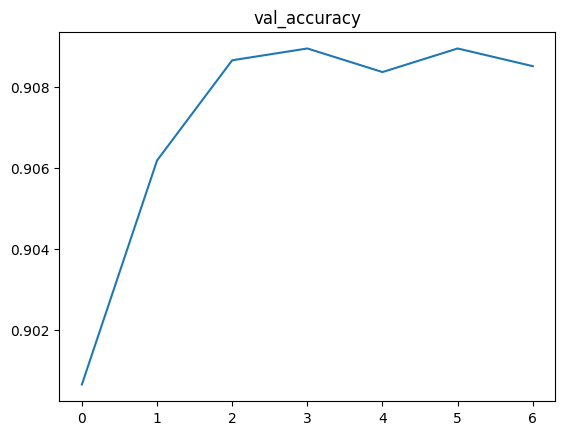

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [57]:
seed(101)
set_seed(101)

ann_model2 = Sequential()

ann_model2.add(Dense(units=128, activation = 'relu'))
ann_model2.add(Dropout(0.3))
ann_model2.add(Dense(units=16, activation = 'relu'))
ann_model2.add(Dense(units=1,activation='sigmoid'))
ann_model2 = ANN_model_classification(ann_model2, X_train_sc, y_train, X_test_sc, y_test)

Looks like XGB model performs better then other.

# Validation

In [58]:
val_data_for_model = columns_standardization(data_preparation(validation_df))
val_data_for_model

dum: State: WY  dum: State: WV  dum: State: WI  dum: State: WA  \
16134               0               0               0               0   
37390               0               0               0               0   
374                 0               0               0               0   
12536               0               0               0               0   
37764               0               0               0               0   
...               ...             ...             ...             ...   
21282               0               0               0               0   
1601                0               0               0               0   
24439               0               0               0               0   
22197               0               0               0               0   
17482               0               0               0               0   

       dum: State: VT  dum: State: VA  dum: State: UT  dum: State: TX  \
16134               0               0               0               0   
37390               0               0               0               1   
374                 0               0               0               0   
12536               0               0               0               0   
37764               0               0               0               1   
...               ...             ...             ...             ...   
21282               0               0               0               0   
1601                0               0               0               0   
24439               0               0               0               0   
22197               0               0               0               0   
17482               0               0               0               0   

       dum: State: TN  dum: State: SD  dum: State: SC  dum: State: RI  \
16134               0               0               0               0   
37390               0               0               0               0   
374                 0               0               0               0   
12536               0               0               0               0   
37764               0               0               0               0   
...               ...             ...             ...             ...   
21282               0               0               0               0   
1601                0               0               0               0   
24439               0               0               0               0   
22197               0               0               0               0   
17482               0               0               0               0   

       dum: State: PA  dum: State: OR  dum: State: OK  dum: State: OH  \
16134               0               0               0               0   
37390               0               0               0               0   
374                 0               0               0               0   
12536               0               0               0               0   
37764               0               0               0               0   
...               ...             ...             ...             ...   
21282               0               0               0               0   
1601                0               0               1               0   
24439               0               0               1               0   
22197               0               0               0               0   
17482               0               0               0               0   

       dum: State: NY  dum: State: NV  dum: State: NM  dum: State: NJ  \
16134               1               0               0               0   
37390               0               0               0               0   
374                 0               0               0               0   
12536               1               0               0               0   
37764               0               0               0               0   
...               ...             ...             ...        

In [59]:
val_data_for_model[val_data_for_model.isnull().any(axis=1)]

Empty DataFrame
Columns: [dum: State: WY, dum: State: WV, dum: State: WI, dum: State: WA, dum: State: VT, dum: State: VA, dum: State: UT, dum: State: TX, dum: State: TN, dum: State: SD, dum: State: SC, dum: State: RI, dum: State: PA, dum: State: OR, dum: State: OK, dum: State: OH, dum: State: NY, dum: State: NV, dum: State: NM, dum: State: NJ, dum: State: NH, dum: State: NE, dum: State: ND, dum: State: NC, dum: State: MT, dum: State: MS, dum: State: MO, dum: State: MN, dum: State: MI, dum: State: ME, dum: State: MD, dum: State: MA, dum: State: LA, dum: State: KY, dum: State: KS, dum: State: IN, dum: State: IL, dum: State: ID, dum: State: IA, dum: State: HI, dum: State: GA, dum: State: FL, dum: State: DE, dum: State: DC, dum: State: CT, dum: State: CO, dum: State: CA, dum: State: AZ, dum: State: AR, dum: State: AL, dum: Sector: 81, dum: Sector: 72, dum: Sector: 71, dum: Sector: 62, dum: Sector: 61, dum: Sector: 56, dum: Sector: 55, dum: Sector: 54, dum: Sector: 53, dum: Sector: 52, dum: Sector: 51, dum: Sector: 49, dum: Sector: 48, dum: Sector: 45, dum: Sector: 44, dum: Sector: 42, dum: Sector: 33, dum: Sector: 32, dum: Sector: 31, dum: Sector: 23, dum: Sector: 22, dum: Sector: 21, dum: Sector: 11, dum: RevLineCr: no data, dum: RevLineCr: Y, dum: RevLineCr: T, dum: RevLineCr: N, dum: NewExist: 2.0, dum: LowDoc: no data, dum: LowDoc: Y, dum: LowDoc: S, dum: LowDoc: N, dum: LowDoc: C, dum: LowDoc: A, dum: City: other, dum: BankState: no data, dum: BankState: WY, dum: BankState: WV, dum: BankState: WI, dum: BankState: WA, dum: BankState: VT, dum: BankState: VA, dum: BankState: UT, dum: BankState: TX, dum: BankState: TN, dum: BankState: SD, dum: BankState: SC, dum: BankState: RI, dum: BankState: PA, dum: BankState: OR, ...]
Index: []

In [60]:
X_validation = val_data_for_model.drop('MIS_Status', axis = 1)
y_validation = val_data_for_model['MIS_Status']

In [61]:
pred = xgbr.predict(X_validation)
print(classification_report(y_validation, pred))
print(confusion_matrix(y_validation, pred))

              precision    recall  f1-score   support

           0       0.64      0.20      0.31      1608
           1       0.91      0.99      0.95     13200

    accuracy                           0.90     14808
   macro avg       0.77      0.59      0.63     14808
weighted avg       0.88      0.90      0.88     14808

[[  324  1284]
 [  183 13017]]


Model showed quite good result on validation data

In [62]:
accuracy_score(y_validation,pred)

0.9009319286871961